In [ ]:
print("project big data")

In [2]:
pip install sparqlwrapper

In [ ]:
mkdir images
mkdir json

### Importer les images des villes depuis Wikidata

In [12]:
"""
Import data images from Wikidata
"""
import sys
import os
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.parse import urlparse, unquote
import requests
import shutil


def get_results(endpoint_url, query):
    """
    Get results from a SPARQL query
    """
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


endpoint_url = "https://query.wikidata.org/sparql"

# Get cities
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q1549591;
               wdt:P17 ?pays;
               wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 100"""

results = get_results(endpoint_url, query)

array = []
for result in results["results"]["bindings"]:
    array.append(
        (
            result["grandevilleLabel"]["value"],
            result["paysLabel"]["value"],
            result["image"]["value"],
        )
    )

"""
Format and print data images
"""
dataframe = pd.DataFrame(array, columns=["ville", "pays", "image"])
dataframe = dataframe.astype(
    dtype={"ville": "<U200", "pays": "<U200", "image": "<U200"}
)
print(dataframe)

def download_image(url, counter=0):
    """
    Download an image from an URL and save it to the 'images/' directory
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        filename = f"img{counter}.jpg"
        images_dir = os.path.join(os.getcwd(), "images")
        if not os.path.isdir(images_dir):
            os.mkdir(images_dir)
        path = os.path.join(images_dir, filename)
        with open(path, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    else:
        print(f"Error downloading {url}. Status code: {request.status_code}")
    return request.status_code


# Download each image
print("Starts downloading")
for i, row in dataframe.iterrows():
    download_image(row["image"], i+1)
    print(f"\rDownloading images {i+1}/{dataframe.shape[0]}", end='')
print("\nDone")


           ville        pays  \
0    Krasnoïarsk      Russie   
1      São Paulo      Brésil   
2         Boston  États-Unis   
3       Le Caire      Égypte   
4       Szczecin     Pologne   
..           ...         ...   
95  Buenos Aires   Argentine   
96          Lyon      France   
97       Le Mans      France   
98      New York  États-Unis   
99     Islamabad    Pakistan   

                                                image  
0   http://commons.wikimedia.org/wiki/Special:File...  
1   http://commons.wikimedia.org/wiki/Special:File...  
2   http://commons.wikimedia.org/wiki/Special:File...  
3   http://commons.wikimedia.org/wiki/Special:File...  
4   http://commons.wikimedia.org/wiki/Special:File...  
..                                                ...  
95  http://commons.wikimedia.org/wiki/Special:File...  
96  http://commons.wikimedia.org/wiki/Special:File...  
97  http://commons.wikimedia.org/wiki/Special:File...  
98  http://commons.wikimedia.org/wiki/Special:File...  

### Enregistrer les metadata Exif de toutes les images dans un fichier metadata.json

In [80]:
"""
Save metadata Exif of all images into 'json/metadata.json' file
"""
from PIL import Image, ExifTags
from PIL.ExifTags import TAGS
import json
import os
from datetime import datetime
import Services as tool

def get_orientation_data(orientation):
    """
    Return orientation tag according to exif value
    """
    if orientation == 3 or orientation == 6 or orientation == 8:
        return 'landscape'
    else:
        return 'portrait'
    
def get_size_data(size):
    """
    Return size data according to it's digital value
    """
    width, height = size
    # déterminer si l'image est une vignette ou de taille moyenne
    if width <= 150 and height <= 150:
        return 'thumbnail'
    elif width <= 800 and height <= 800:
        return 'medium'
    else:
        return 'large'

def get_date_data(value):
    """
    Return date in format '%Y-%m-%d %H:%M:%S'
    """
    datetime_object = datetime.strptime(value, '%Y:%m:%d %H:%M:%S')
    return datetime_object.strftime('%Y-%m-%d %H:%M:%S')
    
def save_metadata_to_json(metadata, output_file):
    """
    Save a dictionary containing metadata in an outputfile
    """
    with open(output_file, 'w') as f:
        json.dump(metadata, f, indent=4)
        
def get_image_metadata(image_path):
    """
    Return a dictionary containing metadata of a given image
    """
    with Image.open(image_path) as img:
        metadata = {}
        metadata['filename'] = os.path.basename(image_path)
        metadata['size'] = get_size_data(img.size)
        metadata['format'] = img.format
        metadata['type'] = img.mode
        metadata['mode'] = 'unknown'
        metadata['Software'] = 'unknown'
        metadata['DateTime'] =  str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        metadata['ColorSpace'] = 'unknown'
        metadata['Model'] = 'unknown'
        try:
                exif_data = img._getexif()
                if exif_data:
                    for tag, value in exif_data.items():
                        if tag in TAGS:
                            # Récupérer le nom du tag
                            tag_name = TAGS[tag]
                            # Ajouter la valeur dans le dictionnaire sous le nom de tag correspondant
                            if tag_name == "ColorSpace" or tag_name == "Software" or tag_name == "Model":
                                metadata[tag_name] = value
                            elif tag_name == "DateTime":
                                # Convert the DateTime value to a standardized format
                                metadata[tag_name] = get_date_data(value)
                            elif tag_name == "Orientation":
                                metadata['mode'] = get_orientation_data(value)
                else:
                    pass
                    
                    # print(f"no exif data for image {os.path.basename(image_path)}")
        except Exception as e:
            
            print(f"Bad EXIF Attribute {e}")
    return metadata

def get_all_image_metadata(folder_path):
    """
    Return a dictionary containing metadata of all image in the folder
    """
    metadata_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            path = os.path.join(folder_path, filename)
            print(f"Get metadata of {filename}")
            metadata = get_image_metadata(path)
            metadata_dict[filename] = metadata
    print()
    return metadata_dict

# Extract data
folder_path = os.path.join(os.getcwd(), "images")
metadata_all = get_all_image_metadata(folder_path)
# Save data in file
tool.write_metadata(metadata_all)
print("Metadata saved into 'json/metadata.json'")

Bad EXIF Attribute time data '2016.08.08 12:34:00' does not match format '%Y:%m:%d %H:%M:%S'
Bad EXIF Attribute unconverted data remains:  
Bad EXIF Attribute unconverted data remains:  

Metadata saved into 'json/metadata.json'


In [ ]:
pip install opencv-python-headless

### Ajouter une metadata pour la couleure dominante, la variance et la couleur moyenne

In [3]:
"""
Set a metadata 'color', 'variance', and 'average' for each images using histogram
"""
import Services as tool
from PIL import Image
from PIL import ImageOps
import colorsys
import os
import json
import numpy as np


def load_images():
    """
    Load all images once
    """
    path = 'images/'
    files = os.listdir(path)
    images = {}
    for file in files:
        if tool.is_file_valid(file):
            print(f"\rLoading and resizing {file}\t", end='')
            img_path = f"{path}{file}"
            img = Image.open(img_path)
            img = ImageOps.fit(img, (400, 400), Image.ANTIALIAS)
            images[file] = img
    print(f"\nLoading done")
    return images

def get_rgb_color(img):
    """
    Return the dominant color of an image using histogram
    """
    # Calculer l'histogramme
    hist = img.histogram()

    # Normaliser l'histogramme
    total_pixels = img.size[0] * img.size[1]
    hist_norm = [float(h) / total_pixels for h in hist]

    # Trouver la couleur dominante
    max_value = max(hist_norm)
    max_index = hist_norm.index(max_value)
    color_hsv = (max_index / 255.0, 1.0, 1.0)

    # Convertir la couleur en RGB
    color_rgb = tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*color_hsv))

    return color_rgb


def get_average_colors_and_variances(img):
    """
    Return the average of red, blue and green and their variances of the selected image
    """
    # Récupérer les données des pixels
    pixels = np.array(img.getdata())

    # Calculer les moyennes
    avg_red, avg_green, avg_blue, *_ = np.mean(pixels, axis=0)

    # Calculer les variances
    var_red, var_green, var_blue,*_ = np.var(pixels, axis=0)
    
    liste_avg = [avg_red, avg_green, avg_blue]
    liste_variance = [var_red, var_green, var_blue]
    return liste_avg, liste_variance

def set_color_tag(img_name, img_path, data):
    """
    Set the color of the image into metadata
    """
    color_rgb = get_rgb_color(img_path)
    data[img_name]["rgb"] = [int(x) for x in color_rgb] 
    return data
    

def set_color_average_and_variance(img_name, img, data):
    """
    Set the average RGB and variances into metadata
    """
    average_rgb, variances_rgb = get_average_colors_and_variances(img)
    data[img_name]["average_rgb"] = [int(x) for x in average_rgb] 
    data[img_name]["variances_rgb"] = [int(x) for x in variances_rgb] 
    return data

def add_new_metadata():
    """
    Set the color tag for all cluster
    """
    data = tool.get_json_metadata()
    # Get a list of all the files in the "images" directory
    images = load_images()
    print()
    for img_name, image in images.items():
        print(f"\rAdding color metadata of {img_name}\t", end='')
        data = set_color_tag(img_name, image, data=data)
        data = set_color_average_and_variance(img_name, image, data=data)
    print(f"\nAdding color done")
    # Save new metadata into file
    tool.write_metadata(data)
    
add_new_metadata()

Loading and resizing img70.jpg		
Loading done

Adding color metadata of img70.jpg		
Adding color done


### Déterminer le nombre K optimal de clusters avec Kmeans

Computing optimal clustering number K...


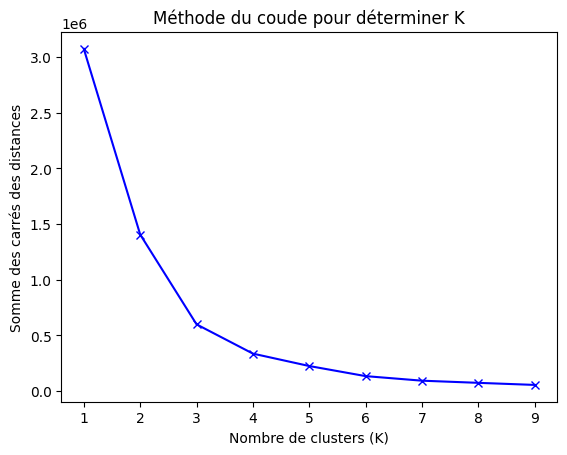

In [82]:
"""
Determine optimal number k of clusters to perform for kmeans
"""
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json
import Services as tool

# Charger les données
metadata = tool.get_json_metadata()

print("Computing optimal clustering number K...")

# Extraire les valeurs de chaque image
data = []
for key in metadata:
    data.append(metadata[key]['rgb'])
    
# Initialiser une liste pour stocker les valeurs de la somme des carrés des distances
sum_of_squared_distances = []

# Tester K-means pour différentes valeurs de K
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data)
    sum_of_squared_distances.append(kmeans.inertia_)

# Tracer le graphique de la somme des carrés des distances en fonction de K
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Somme des carrés des distances')
plt.title('Méthode du coude pour déterminer K')
plt.show()

### Performer clusterings des images en utilisant couleurs dominantes et variances

In [83]:
"""
Perform a clustering on metadata rgb of all images using Kmeans
"""
import json
from sklearn.cluster import KMeans
import Services as tool

def cluster_images(metadata, cluster, feature_name, K):
    print(f"KMeans perform clustering {cluster}...")
    # Extraire les valeurs de chaque image
    X = []
    for key in metadata:
        X.append(metadata[key][feature_name])

    # Effectuer le clustering
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(X)

    # Convertir le tableau d'étiquettes en une liste Python
    labels = kmeans.labels_.tolist()

    # Ajouter la métadonnée "cluster" à chaque image
    for i, key in enumerate(metadata):
        metadata[key][cluster] = labels[i]
    
    return metadata

# Charger les données à partir du fichier JSON
metadata = tool.get_json_metadata()

# Effectuer le clustering sur la caractéristique "rgb"
metadata = cluster_images(metadata, cluster='cluster_rgb', feature_name='rgb', K=5) # K = 5 according to previous charts

# Effectuer le clustering sur la caractéristique "variance_rgb"
metadata = cluster_images(metadata, cluster='cluster_variance', feature_name='variances_rgb', K=5)

print("Done")
tool.write_metadata(metadata)

KMeans perform clustering cluster_rgb...
KMeans perform clustering cluster_variance...
Done


In [16]:
pip install python-dateutil

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Performer un clustering sur les périodes temporelles

In [84]:
"""
Perform a clustering period on the time of day { morning, day, night }
"""
import json
import Services as tool
from datetime import datetime
from dateutil import parser

metadata = tool.get_json_metadata()

features = []

print("Perform clustering on Period...")
for filename, data in metadata.items():
    datetime_str = data['DateTime']
    
    # Extraire l'heure de la journée de la chaîne de caractères DateTime
    datetime_obj = parser.parse(datetime_str)

    # Extraire l'heure de la journée
    heure = datetime_obj.time().hour

    # Déterminer si l'heure est le matin, l'après-midi ou la nuit
    if heure >= 6 and heure < 12:
        features.append("morning")
    elif heure >= 12 and heure < 18:
        features.append("day")
    else:
        features.append("night")

# Ajouter la métadonnée "moment" à chaque image
for i, key in enumerate(metadata):
    metadata[key]['moment'] = features[i]

print("Done")
tool.write_metadata(metadata)

Perform clustering on Period...
Done


### Tagger les images

In [5]:
!pip install tensorflow
!pip install pillow
!pip install numpy

Loading and resizing img70.jpg		
Loading done


In [15]:
"""
Automatisation tag image
[NO MORE USE]
"""
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
import numpy as np

# Do not use here -> Always return same tags
model = MobileNetV2(weights='imagenet')

path = 'images/'
files = os.listdir(path)
images = {}
for file in files:
    if tool.is_file_valid(file):
        print(f"\rLoading and resizing {file}\t", end='')
        image_path = f"{path}{file}"
            
#for img_name, image in images.items():
    # Charger l'image et la redimensionner
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)

        # Prétraiter l'image
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        # Prétraiter l'image
        preprocessed_image = preprocess_input(image.reshape(1, 224, 224, 3))

        # Prédire le tag de l'image
        predictions = model.predict(preprocessed_image)
        tags = decode_predictions(predictions, top=10)[0]

        for tag in tags:
            print(f"{file} with tag: {tag[1]}")



1/1 [==============================] - 2s 2s/step
img90.jpg with tag: spotlight
img90.jpg with tag: digital_clock
img90.jpg with tag: matchstick
img90.jpg with tag: theater_curtain
img90.jpg with tag: lampshade
img90.jpg with tag: candle
img90.jpg with tag: switch
img90.jpg with tag: velvet
img90.jpg with tag: wall_clock
img90.jpg with tag: screw
1/1 [==============================] - 0s 92ms/step
img26.jpg with tag: spotlight
img26.jpg with tag: digital_clock
img26.jpg with tag: lampshade
img26.jpg with tag: theater_curtain
img26.jpg with tag: matchstick
img26.jpg with tag: candle
img26.jpg with tag: velvet
img26.jpg with tag: switch
img26.jpg with tag: wall_clock
img26.jpg with tag: window_shade
1/1 [==============================] - 0s 116ms/step
img19.jpg with tag: spotlight
img19.jpg with tag: digital_clock
img19.jpg with tag: matchstick
img19.jpg with tag: theater_curtain
img19.jpg with tag: lampshade
img19.jpg with tag: switch
img19.jpg with tag: candle
img19.jpg with tag: velve

1/1 [==============================] - 0s 114ms/step
img84.jpg with tag: spotlight
img84.jpg with tag: digital_clock
img84.jpg with tag: matchstick
img84.jpg with tag: lampshade
img84.jpg with tag: switch
img84.jpg with tag: candle
img84.jpg with tag: screw
img84.jpg with tag: theater_curtain
img84.jpg with tag: wall_clock
img84.jpg with tag: traffic_light
1/1 [==============================] - 0s 109ms/step
img23.jpg with tag: theater_curtain
img23.jpg with tag: spotlight
img23.jpg with tag: velvet
img23.jpg with tag: lampshade
img23.jpg with tag: window_shade
img23.jpg with tag: digital_clock
img23.jpg with tag: abaya
img23.jpg with tag: space_heater
img23.jpg with tag: projector
img23.jpg with tag: seashore
1/1 [==============================] - 0s 105ms/step
img9.jpg with tag: spotlight
img9.jpg with tag: digital_clock
img9.jpg with tag: theater_curtain
img9.jpg with tag: matchstick
img9.jpg with tag: lampshade
img9.jpg with tag: switch
img9.jpg with tag: candle
img9.jpg with tag: 

1/1 [==============================] - 0s 100ms/step
img40.jpg with tag: spotlight
img40.jpg with tag: digital_clock
img40.jpg with tag: velvet
img40.jpg with tag: matchstick
img40.jpg with tag: lampshade
img40.jpg with tag: candle
img40.jpg with tag: switch
img40.jpg with tag: theater_curtain
img40.jpg with tag: wall_clock
img40.jpg with tag: window_shade
1/1 [==============================] - 0s 89ms/step
img68.jpg with tag: spotlight
img68.jpg with tag: theater_curtain
img68.jpg with tag: digital_clock
img68.jpg with tag: velvet
img68.jpg with tag: lampshade
img68.jpg with tag: matchstick
img68.jpg with tag: candle
img68.jpg with tag: window_shade
img68.jpg with tag: wall_clock
img68.jpg with tag: switch
1/1 [==============================] - 0s 98ms/step
img55.jpg with tag: spotlight
img55.jpg with tag: digital_clock
img55.jpg with tag: matchstick
img55.jpg with tag: theater_curtain
img55.jpg with tag: lampshade
img55.jpg with tag: switch
img55.jpg with tag: candle
img55.jpg with t

1/1 [==============================] - 0s 102ms/step
img20.jpg with tag: spotlight
img20.jpg with tag: digital_clock
img20.jpg with tag: matchstick
img20.jpg with tag: lampshade
img20.jpg with tag: theater_curtain
img20.jpg with tag: candle
img20.jpg with tag: switch
img20.jpg with tag: velvet
img20.jpg with tag: wall_clock
img20.jpg with tag: window_shade
1/1 [==============================] - 0s 120ms/step
img49.jpg with tag: spotlight
img49.jpg with tag: digital_clock
img49.jpg with tag: matchstick
img49.jpg with tag: velvet
img49.jpg with tag: lampshade
img49.jpg with tag: theater_curtain
img49.jpg with tag: wall_clock
img49.jpg with tag: candle
img49.jpg with tag: window_shade
img49.jpg with tag: switch
1/1 [==============================] - 0s 121ms/step
img81.jpg with tag: spotlight
img81.jpg with tag: digital_clock
img81.jpg with tag: theater_curtain
img81.jpg with tag: lampshade
img81.jpg with tag: matchstick
img81.jpg with tag: velvet
img81.jpg with tag: candle
img81.jpg with

1/1 [==============================] - 0s 89ms/step
img13.jpg with tag: spotlight
img13.jpg with tag: digital_clock
img13.jpg with tag: matchstick
img13.jpg with tag: lampshade
img13.jpg with tag: theater_curtain
img13.jpg with tag: switch
img13.jpg with tag: screw
img13.jpg with tag: candle
img13.jpg with tag: wall_clock
img13.jpg with tag: loudspeaker
1/1 [==============================] - 0s 99ms/step
img95.jpg with tag: spotlight
img95.jpg with tag: digital_clock
img95.jpg with tag: lampshade
img95.jpg with tag: matchstick
img95.jpg with tag: theater_curtain
img95.jpg with tag: candle
img95.jpg with tag: switch
img95.jpg with tag: velvet
img95.jpg with tag: wall_clock
img95.jpg with tag: screw
1/1 [==============================] - 0s 94ms/step
img72.jpg with tag: spotlight
img72.jpg with tag: lampshade
img72.jpg with tag: theater_curtain
img72.jpg with tag: digital_clock
img72.jpg with tag: matchstick
img72.jpg with tag: velvet
img72.jpg with tag: candle
img72.jpg with tag: window

In [85]:
"""
Demander à l'utilisateur de tagger les images
"""
import json
import Services as tool
from datetime import datetime
import random

list_tag = ['nature', 'mountain', 'landscape', 'sunset', 'sea']

metadata = tool.get_json_metadata()

print("Please tag 5 images")
# Ajouter la métadonnée "moment" à chaque image
for i, key in enumerate(metadata):
    # on tag que les 5 premières images, les autres tags sont aléatoires car beaucoup d'images
    if i < 5:
        tag = str(input(f"Enter tag for image {key}: "))
        metadata[key]['tag'] = tag
    else:
        metadata[key]['tag'] = random.choice(list_tag)

tool.write_metadata(metadata)

Please tag 5 images
Enter tag for image img90.jpg: nature
Enter tag for image img26.jpg: nature$
Enter tag for image img19.jpg: moutain
Enter tag for image img21.jpg: moutain
Enter tag for image img11.jpg: moutain


## Tests des différents types de classifications
### Classification usnig KNN

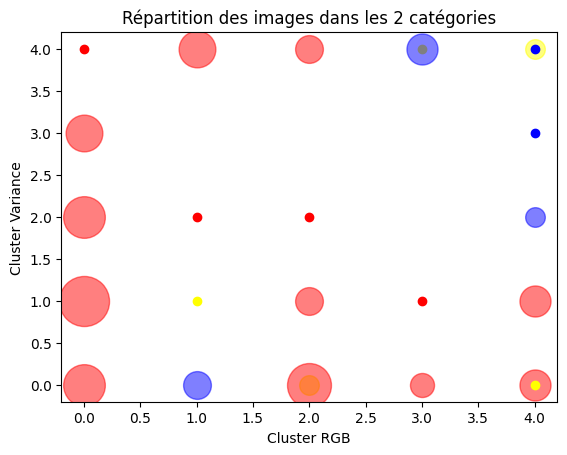

In [86]:
"""
Classification des préférences avec KNN
Demander de sélectionner quelques images et prédire si il faut recommander ou pas les autres
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
import json
import Services as tool
import matplotlib.pyplot as plt
from collections import Counter


# Charger les metadata depuis le fichier JSON
metadata = tool.get_json_metadata()

# Préparer les données d'entraînement et de test
X = []  # caractéristiques des images
y = []  # 0 si l'utilisateur n'aime pas l'image, 1 si l'utilisateur aime l'image

# Sélectionner les images aimées par l'utilisateur
liked_images = [0, 3, 7, 8, 10, 11, 12]

# Créer un vectoriseur de texte
vectorizer = CountVectorizer()

# Associer like ou not like à chaque image
for i, key in enumerate(metadata):
    # Train on 50% of data
    if i >= len(metadata)//2:
        break
    # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
    tags = metadata[key]['tag']
    if len(tags) <= 1: # remplacer la chaîne de caractères "a" par la valeur numérique 0
        tags = 'none'
    # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
     #tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
    # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
     #moment_vector = vectorizer.fit_transform([metadata[key]['moment']]).toarray()[0][0]
    # Ajouter les caractéristiques de l'image i à X
    X.append([metadata[key]['cluster_rgb'], metadata[key]['cluster_variance']])
    
    # Ajouter la réponse de l'utilisateur pour l'image i à y
    if i in liked_images:
        y.append(1)
    else:
        y.append(0)

# Créer un modèle de k-NN avec k=5 voisins
clf = KNeighborsClassifier(n_neighbors=5)

# Entraîner le modèle sur les données d'entraînement
clf.fit(X, y)

# Récupérer les positions des images par rapport au centre de leur cluster
image_positions = []
# Recommander les images similaires à celles aimées par l'utilisateur
recommended_images = []

for i, key in enumerate(metadata):
    if i in liked_images:
        image_positions.append((metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], 'liked'))
    # Vérifier si l'utilisateur a déjà aimé l'image i
    if i not in liked_images:
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags = metadata[key]['tag']
        if len(tags) <= 1: # remplacer la chaîne de caractères "a" par la valeur numérique 0
            tags = 'none'
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
        moment_vector = vectorizer.fit_transform([metadata[key]['moment']]).toarray()[0][0]
        # Prédire si l'utilisateur aimerait l'image i en utilisant le modèle de k-NN
        prediction = clf.predict([[metadata[key]['cluster_rgb'], metadata[key]['cluster_variance']]])[0]
        # Si la prédiction est positive, ajouter l'image i aux images recommandées
        if prediction == 1:
            recommended_images.append(key)
            image_positions.append((metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], 'recommended'))
        else:
            image_positions.append((metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], 'not recommended'))

            #print(recommended_images)

# Créer un dictionnaire pour associer les étiquettes de couleur à chaque catégorie d'image
colors = {'liked': 'yellow', 'recommended': 'blue', 'not recommended': 'red'}
# Compter le nombre de points à chaque emplacement
count = Counter(image_positions)

# Afficher le nuage de points en parcourant chaque emplacement
for (x, y, label), size in count.items():
    if size > 1: # dessiner un point plus gros si le nombre de points est supérieur à 1
        plt.scatter(x, y, s=100*size, color=colors[label], alpha=0.5)
    else:
        plt.scatter(x, y, color=colors[label])

# Ajouter les étiquettes des axes et le titre du graphique
plt.xlabel('Cluster RGB')
plt.ylabel('Cluster Variance')
plt.title('Répartition des images dans les 2 catégories')

# Afficher le graphique
plt.show()


### Classification avec Decision Tree

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.00      0.00      0.00         5

    accuracy                           0.55        20
   macro avg       0.34      0.37      0.35        20
weighted avg       0.52      0.55      0.53        20



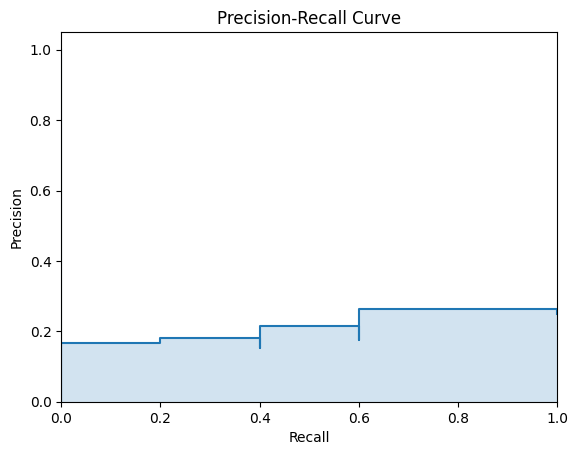

recommended
recommended
recommended
recommended
recommended
recommended
recommended
recommended
recommended
recommended


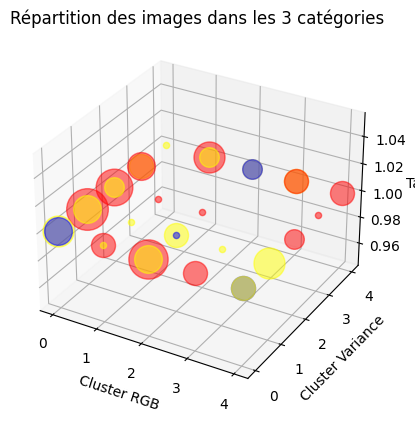

In [108]:
"""
Classification des préférences des utilisateurs avec Decision Tree
"""

from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn import datasets, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import Services as tool
import random


def prediction(model):
    # Charger les metadata depuis le fichier JSON
    metadata = tool.get_json_metadata()

    # Sélectionner aléatoirement n images aimées par l'utilisateur
    n = 40
    liked_images = set()
    while len(liked_images) < n:
        liked_images.add(random.randint(0, 100))

    liked_images = list(liked_images)

    # Préparer les données d'entraînement et de test
    X = []  # caractéristiques des images
    y = []  # 0 si l'utilisateur n'aime pas l'image, 1 si l'utilisateur aime l'image

    # Créer un vectoriseur de texte
    vectorizer = CountVectorizer()

    for i, key in enumerate(metadata):
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags = metadata[key]['tag']
        try:
            # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
            tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
        except:
            tags_vector = 0

        # Ajouter les caractéristiques de l'image i à X
        X.append([metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector])

        # Ajouter la réponse de l'utilisateur pour l'image i à y
        if i in liked_images:
            y.append(1)
        else:
            y.append(0)


    # Fractionnement des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entraînement de l'arbre de décision
    dt = model()
    # Entraîner le modèle sur les données d'entraînement
    dt.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = dt.predict(X_test)
    # Obtenir les probabilités pour chaque classe (0 ou 1) pour chaque exemple dans l'ensemble de test
    y_prob = dt.predict_proba(X_test)
    # Extraire la probabilité pour la classe positive (1)
    y_score = y_prob[:, 1]

    # Afficher les statistiques de classification
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, where='post')
    plt.fill_between(recall, precision, alpha=0.2, step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()



    # Récupérer les positions des images par rapport au centre de leur cluster
    image_positions = []
    # Recommander les images similaires à celles aimées par l'utilisateur
    recommended_images = []

    for i, key in enumerate(metadata):
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags = metadata[key]['tag']
        try:
            # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
            tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
        except:
            tags_vector = 0

        if i in liked_images:
            image_positions.append((metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector, 'liked'))
        # Vérifier si l'utilisateur a déjà aimé l'image i
        if i not in liked_images:

            # Prédire si l'utilisateur aimerait l'image i en utilisant le modèle DecisionTree
            prediction = dt.predict([[metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector]])[0]
            # Si la prédiction est positive, ajouter l'image i aux images recommandées
            if prediction == 1:
                recommended_images.append(key)
                image_positions.append((metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector, 'recommended'))
            else:
                image_positions.append((metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector, 'not recommended'))

                #print(recommended_images)

    """
    Draw charts to visualize results
    """
    # Créer un dictionnaire pour associer les étiquettes de couleur à chaque catégorie d'image
    colors = {'liked': 'yellow', 'recommended': 'blue', 'not recommended': 'red'}
    # Compter le nombre de points à chaque emplacement
    count = Counter(image_positions)

    # 7. Créer un nuage de points en 3D avec des couleurs pour représenter le tag
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Afficher le nuage de points en parcourant chaque emplacement
    for (x, y, tag, label), size in count.items():
        if size > 1: # dessiner un point plus gros si le nombre de points est supérieur à 1
            #plt.scatter(x, y, s=100*size, color=colors[label], alpha=0.5)
            ax.scatter(x, y, tag, c=colors[label], alpha=0.5, s=100*size)
        else:
            ax.scatter(x, y, tag, c=colors[label], alpha=0.5)


    # Ajouter les étiquettes des axes et le titre du graphique
    ax.set_xlabel('Cluster RGB')
    ax.set_ylabel('Cluster Variance')
    ax.set_zlabel('Tag')

    # Ajouter les étiquettes des axes et le titre du graphique
    plt.title('Répartition des images dans les 3 catégories')

    # Afficher le graphique
    plt.show()

prediction(model=DecisionTreeClassifier)

### Classification avec randomForestTree

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.33      0.43      0.38         7

    accuracy                           0.50        20
   macro avg       0.48      0.48      0.48        20
weighted avg       0.53      0.50      0.51        20



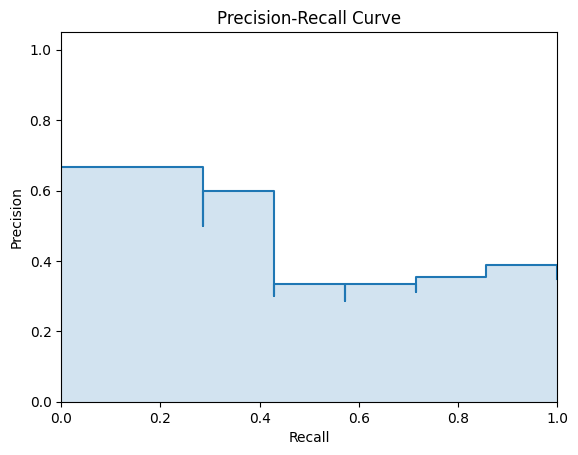

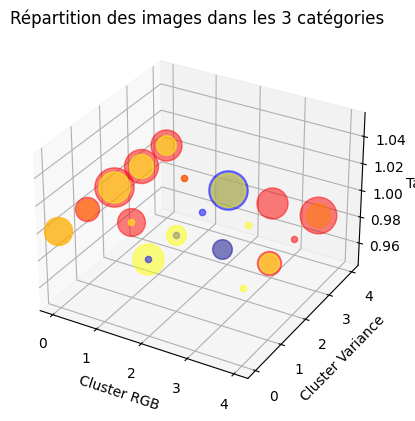

In [52]:
"""
Classification des préférences des utilisateurs avec randomForestTree
"""

from sklearn.ensemble import RandomForestClassifier
prediction(model=RandomForestClassifier)

### Classification avec Perceptron

              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.53      0.89      0.67         9

    accuracy                           0.60        20
   macro avg       0.67      0.63      0.58        20
weighted avg       0.68      0.60      0.58        20



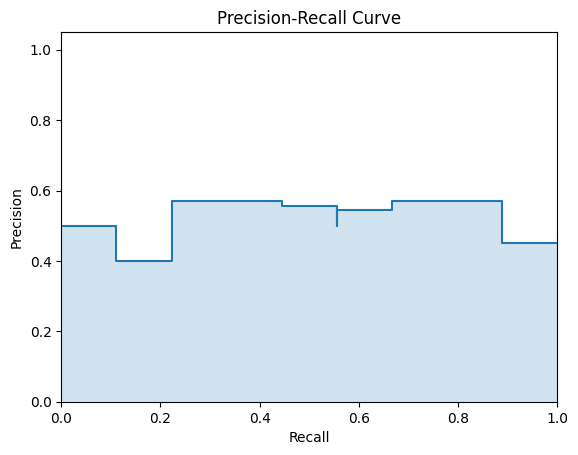

In [56]:
"""
Classification de préférences des utilisateurs avec Pereceptron
"""
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

def prediction(model=Perceptron):
    # Charger les metadata depuis le fichier JSON
    metadata = tool.get_json_metadata()

    # Sélectionner aléatoirement n images aimées par l'utilisateur
    n = 40
    liked_images = set()
    while len(liked_images) < n:
        liked_images.add(random.randint(0, 100))

    liked_images = list(liked_images)

    # Préparer les données d'entraînement et de test
    X = []  # caractéristiques des images
    y = []  # 0 si l'utilisateur n'aime pas l'image, 1 si l'utilisateur aime l'image

    # Créer un vectoriseur de texte
    vectorizer = CountVectorizer()

    for i, key in enumerate(metadata):
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags = metadata[key]['tag']
        try:
            # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
            tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
        except:
            tags_vector = 0

        # Ajouter les caractéristiques de l'image i à X
        X.append([metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector])

        # Ajouter la réponse de l'utilisateur pour l'image i à y
        if i in liked_images:
            y.append(1)
        else:
            y.append(0)


    # Fractionnement des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entraînement du perceptron
    perceptron = model()
    # Entraîner le modèle sur les données d'entraînement
    perceptron.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = perceptron.predict(X_test)
    # Obtenir les probabilités pour chaque classe (0 ou 1) pour chaque exemple dans l'ensemble de test
    y_prob = perceptron.decision_function(X_test)
    # Extraire la probabilité pour la classe positive (1)
    y_score = y_prob

    # Afficher les statistiques de classification
    print(classification_report(y_test, y_pred))


    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, where='post')
    plt.fill_between(recall, precision, alpha=0.2, step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

prediction(Perceptron)

### Prédiction avec MLP Classifier

[[12  3]
 [ 5  0]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.00      0.00      0.00         5

    accuracy                           0.60        20
   macro avg       0.35      0.40      0.38        20
weighted avg       0.53      0.60      0.56        20



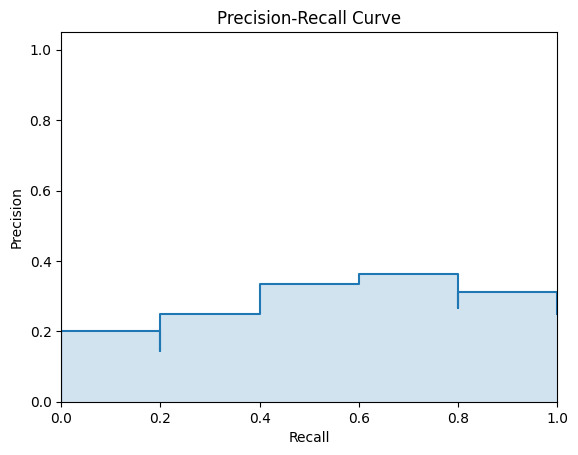

In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import random
import Services as tool
import matplotlib.pyplot as plt

def prediction(model=MLPClassifier):
    # Charger les metadata depuis le fichier JSON
    metadata = tool.get_json_metadata()

    # Sélectionner aléatoirement n images aimées par l'utilisateur
    n = 40
    liked_images = set()
    while len(liked_images) < n:
        liked_images.add(random.randint(0, 100))

    liked_images = list(liked_images)

    # Préparer les données d'entraînement et de test
    X = []  # caractéristiques des images
    y = []  # 0 si l'utilisateur n'aime pas l'image, 1 si l'utilisateur aime l'image

    # Créer un vectoriseur de texte
    vectorizer = CountVectorizer()

    for i, key in enumerate(metadata):
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags = metadata[key]['tag']
        try:
            # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
            tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
        except:
            tags_vector = 0

        # Ajouter les caractéristiques de l'image i à X
        X.append([metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector])

        # Ajouter la réponse de l'utilisateur pour l'image i à y
        if i in liked_images:
            y.append(1)
        else:
            y.append(0)


    # Fractionnement des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entraînement du réseau de neurones
    mlp = model(hidden_layer_sizes=(100,), max_iter=1000)
    # Entraîner le modèle sur les données d'entraînement
    mlp.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = mlp.predict(X_test)
    # Obtenir les probabilités pour chaque classe (0 ou 1) pour chaque exemple dans l'ensemble de test
    y_prob = mlp.predict_proba(X_test)
    # Extraire la probabilité pour la classe positive (1)
    y_score = y_prob[:, 1]

    # Afficher les statistiques de classification
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, where='post')
    plt.fill_between(recall, precision, alpha=0.2, step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

prediction(MLPClassifier)

### Classification avec SVC

              precision    recall  f1-score   support

           0       0.65      0.85      0.73        13
           1       0.33      0.14      0.20         7

    accuracy                           0.60        20
   macro avg       0.49      0.49      0.47        20
weighted avg       0.54      0.60      0.55        20



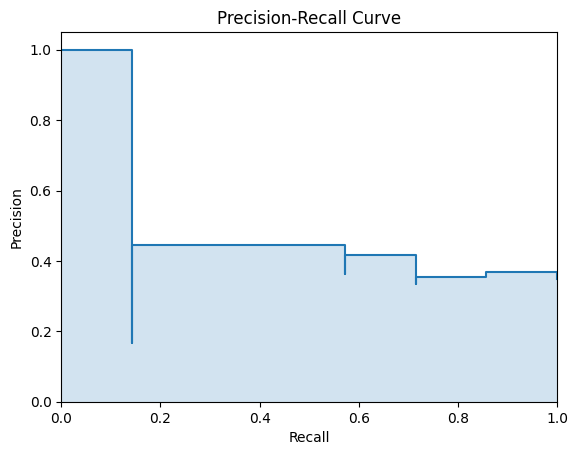

In [66]:
"""
Classification des images utilisant SVC
"""
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import Services as tool

def prediction(model):
    # Charger les metadata depuis le fichier JSON
    metadata = tool.get_json_metadata()

    # Sélectionner aléatoirement n images aimées par l'utilisateur
    n = 40
    liked_images = set()
    while len(liked_images) < n:
        liked_images.add(random.randint(0, 100))

    liked_images = list(liked_images)

    # Préparer les données d'entraînement et de test
    X = []  # caractéristiques des images
    y = []  # 0 si l'utilisateur n'aime pas l'image, 1 si l'utilisateur aime l'image

    # Créer un vectoriseur de texte
    vectorizer = CountVectorizer()

    for i, key in enumerate(metadata):
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags = metadata[key]['tag']
        try:
            # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
            tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
        except:
            tags_vector = 0

        # Ajouter les caractéristiques de l'image i à X
        X.append([metadata[key]['cluster_rgb'], metadata[key]['cluster_variance'], tags_vector])

        # Ajouter la réponse de l'utilisateur pour l'image i à y
        if i in liked_images:
            y.append(1)
        else:
            y.append(0)


    # Fractionnement des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entraînement de l'algorithme SVC
    svc = model(probability=True)
    # Entraîner le modèle sur les données d'entraînement
    svc.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = svc.predict(X_test)
    # Obtenir les probabilités pour chaque classe (0 ou 1) pour chaque exemple dans l'ensemble de test
    y_prob = svc.predict_proba(X_test)
    # Extraire la probabilité pour la classe positive (1)
    y_score = y_prob[:, 1]

    # Afficher les statistiques de classification
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, where='post')
    plt.fill_between(recall, precision, alpha=0.2, step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()
    
prediction(SVC)

## Création profil de préférence de l'utilisateur 

In [93]:
"""
Création profiles préférences des utilisateur 
"""
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import random
from sklearn.feature_extraction.text import CountVectorizer
import Services as tool
from Utilities import NumpyEncoder

def get_liked_images(metadata, selection_random=True):
    liked_images = set()
    if selection_random:
        # Sélectionner aléatoirement n images aimées par l'utilisateur
        n = 40
        while len(liked_images) < n:
            liked_images.add(random.randint(0, 100))
    else:
        # Select num_images random images
        image_ids = random.sample(list(metadata.keys()), num_images)
        liked_images = set()
        for image_id in image_ids:
            print(f"Do you like image {image_id}? (y/n)")
            response = input().lower()
            while response not in ['y', 'n']:
                print("Invalid response. Please enter 'y' or 'n'.")
                response = input().lower()
            if response == 'y':
                liked_images.append(image_id)
    return list(liked_images)
    
def get_preferences(metadata):
    """
    return preferences of a user
    """
    preference_values = {"favorite_images": []}
    for i, key in enumerate(metadata):
        # Ajouter la réponse de l'utilisateur pour l'image i à y
        if i in liked_images:
            preference_values["favorite_images"].append(key)


    image_positions = []
    recommended_images = []
    for i, key in enumerate(metadata):
            positions = [
                metadata[key]['cluster_rgb'], 
                metadata[key]['cluster_variance'], 
                metadata[key]['tag'], 
                metadata[key]['size'], 
                metadata[key]['mode'], 
                metadata[key]['rgb'], 
                metadata[key]['average_rgb']
            ]
            if i in liked_images:
                positions.append('liked')
            # Vérifier si l'utilisateur a déjà aimé l'image i
            if i not in liked_images:
                positions.append('not liked')
            image_positions.append(positions)

  
    user_data = pd.DataFrame(image_positions, columns=['cluster_rgb', 
                                                       'cluster_variance', 
                                                       'tag', 'size', 
                                                       'mode', 'rgb', 
                                                       'average_rgb', 'prediction'
                                                      ])

    recommended_user_data = user_data[(user_data['prediction'] == 'liked')]
    
    #preference_values = {}
    # Boucler sur chaque colonne du DataFrame
    for col in recommended_user_data.columns:
        # Utiliser la méthode value_counts() pour trouver la fréquence d'apparition de chaque valeur dans la colonne
        value_counts = recommended_user_data[col].value_counts()
        
        # Trouver la valeur qui a la fréquence d'apparition la plus grande dans la colonne
        most_frequent_value = value_counts.idxmax()
    
        preference_values[col] = most_frequent_value
    
    #print(f"Recommended img: {recommended_user_data}")
    return preference_values

# analyze user preference profile
num_users = 10
users = []
# Charger les metadata depuis le fichier JSON
metadata = tool.get_json_metadata()
for i in range(num_users):
    print(f"Computing preferences for user n°{i}")
    user = {'user_id': i+1}
    liked_images = get_liked_images(metadata, selection_random=True)
    user_preference = get_preferences(metadata)
    user.update(user_preference)
    users.append(user)

print("Done")
# Save user preferences into JSON file
with open('json/user_preference.json', 'w') as outfile:
    json.dump(users, outfile, indent=4,cls=NumpyEncoder)

Computing preference for user n°0
Computing preference for user n°1
Computing preference for user n°2
Computing preference for user n°3
Computing preference for user n°4
Computing preference for user n°5
Computing preference for user n°6
Computing preference for user n°7
Computing preference for user n°8
Computing preference for user n°9
Done


### Visualisation des données

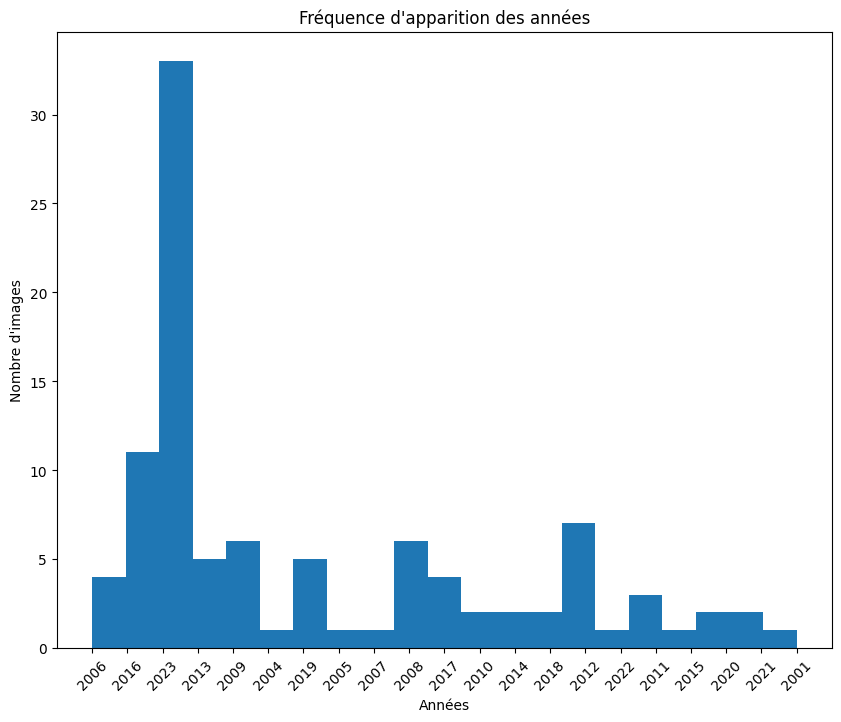

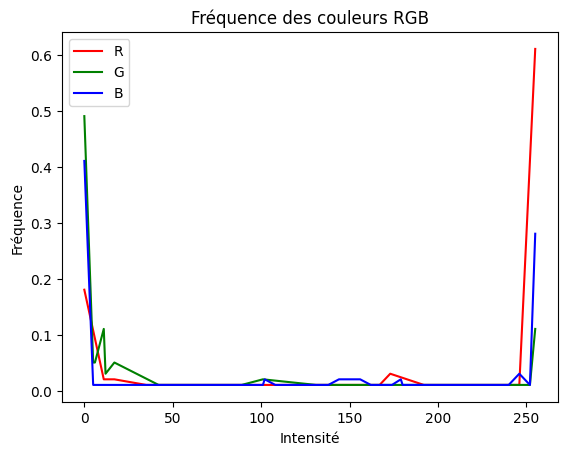

col is size


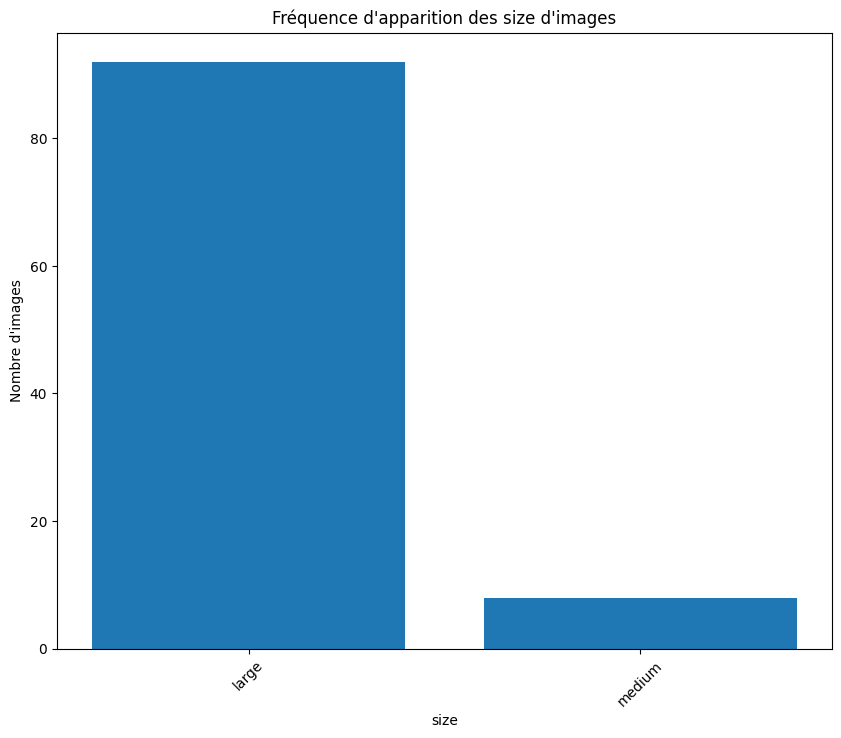

col is format


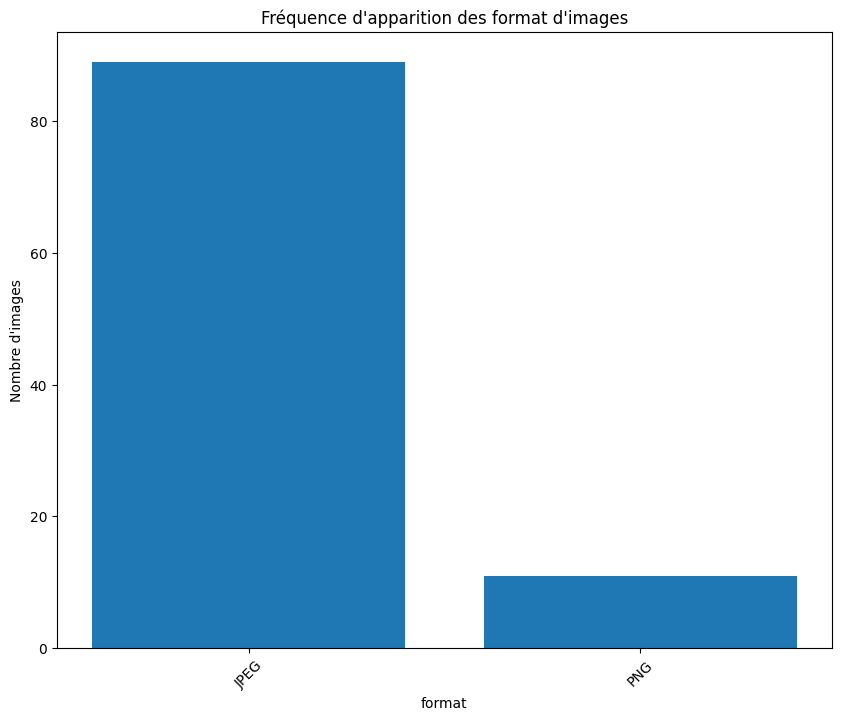

col is type


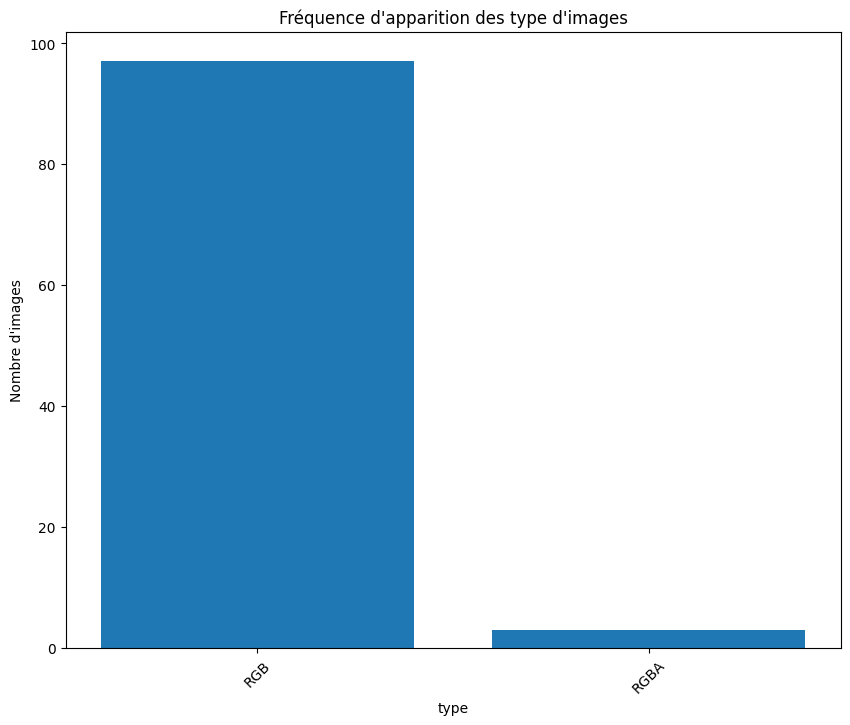

col is mode


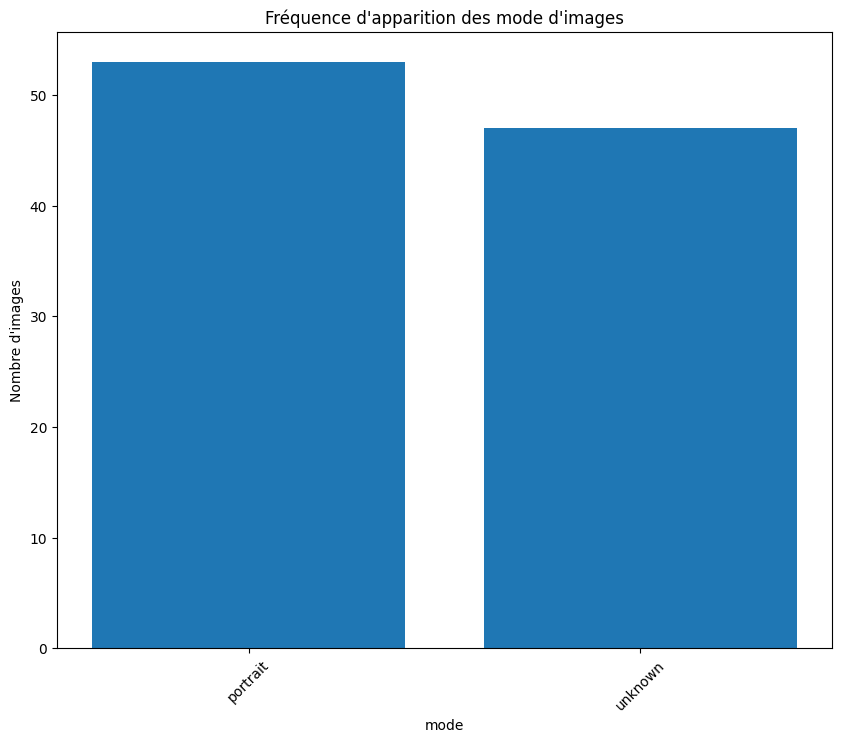

col is Software


/home/user/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


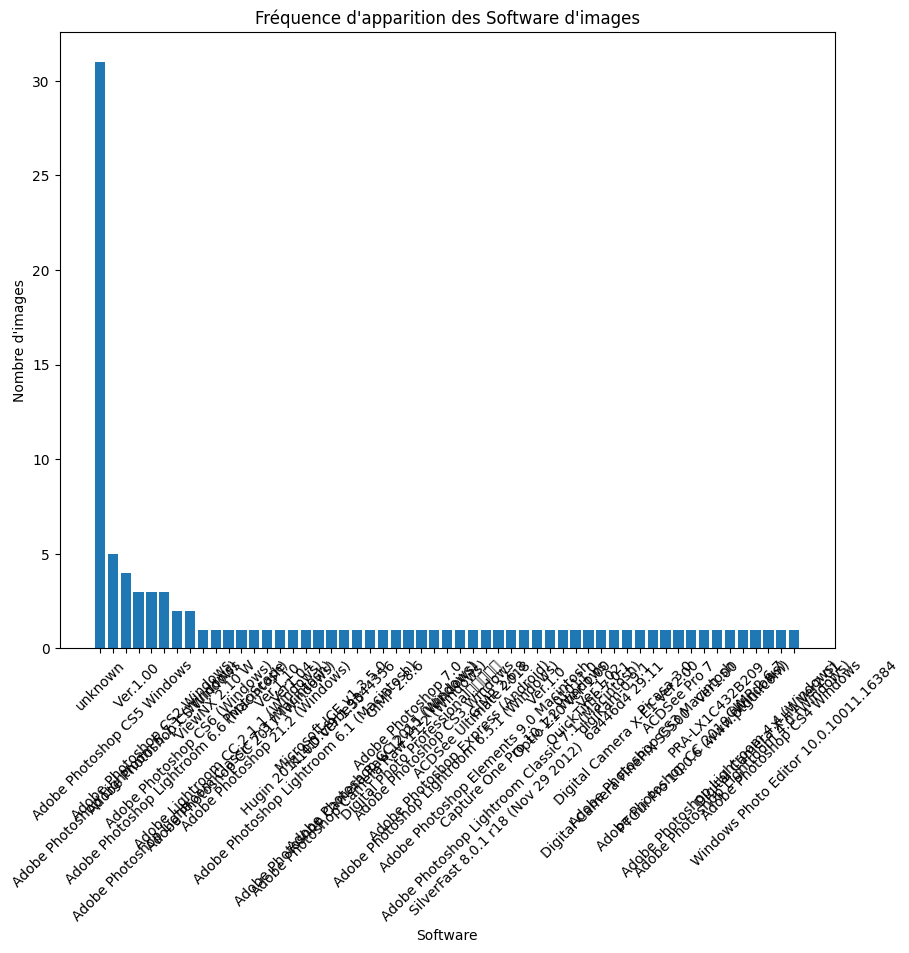

col is Model


/home/user/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


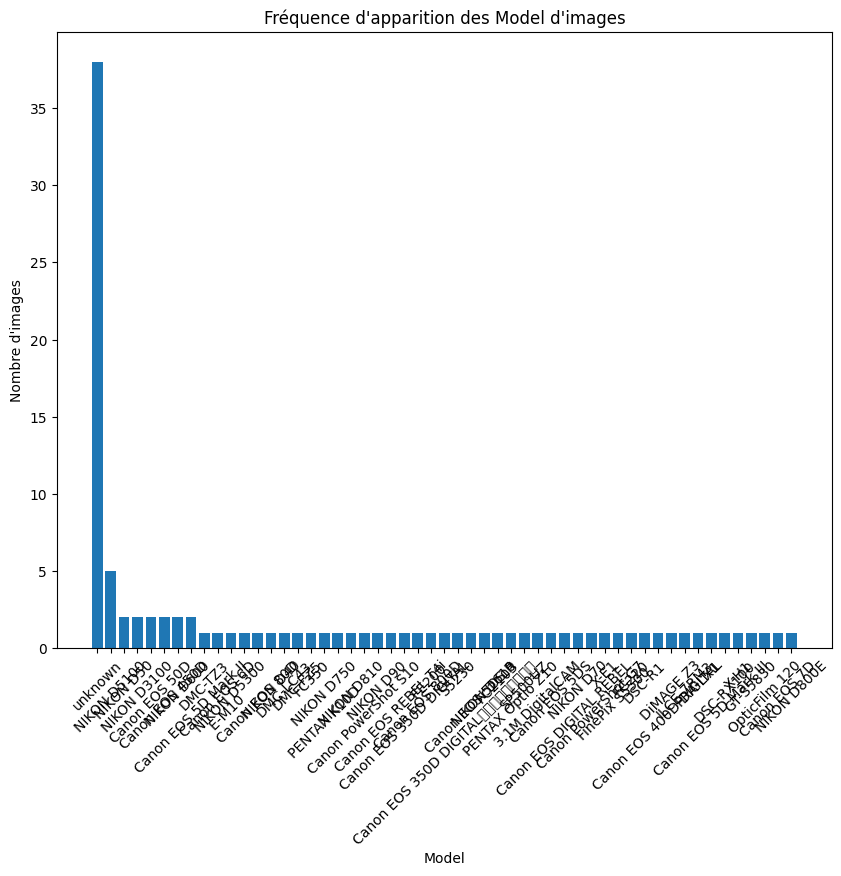

col is cluster_rgb


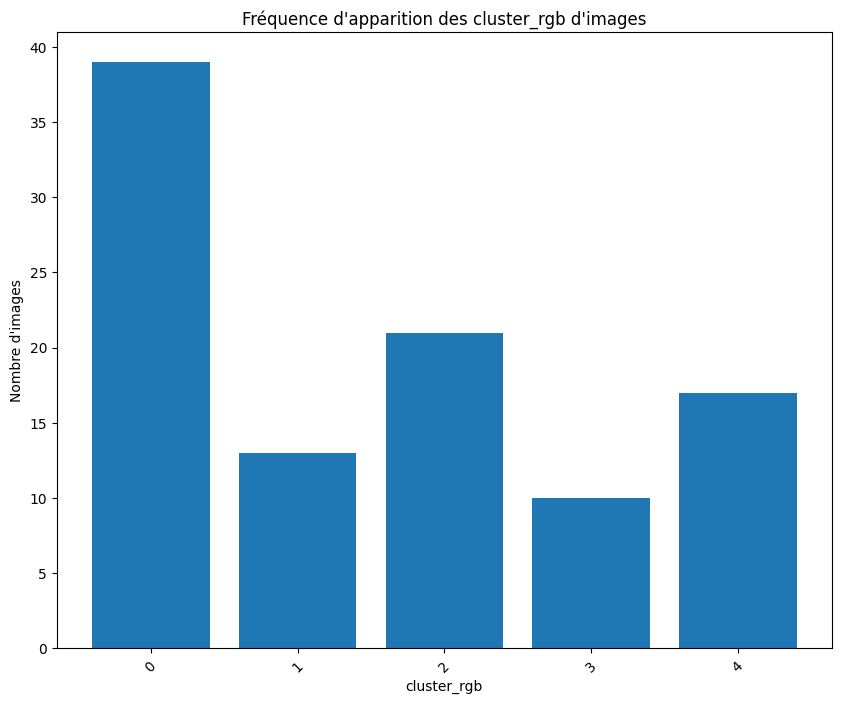

col is cluster_variance


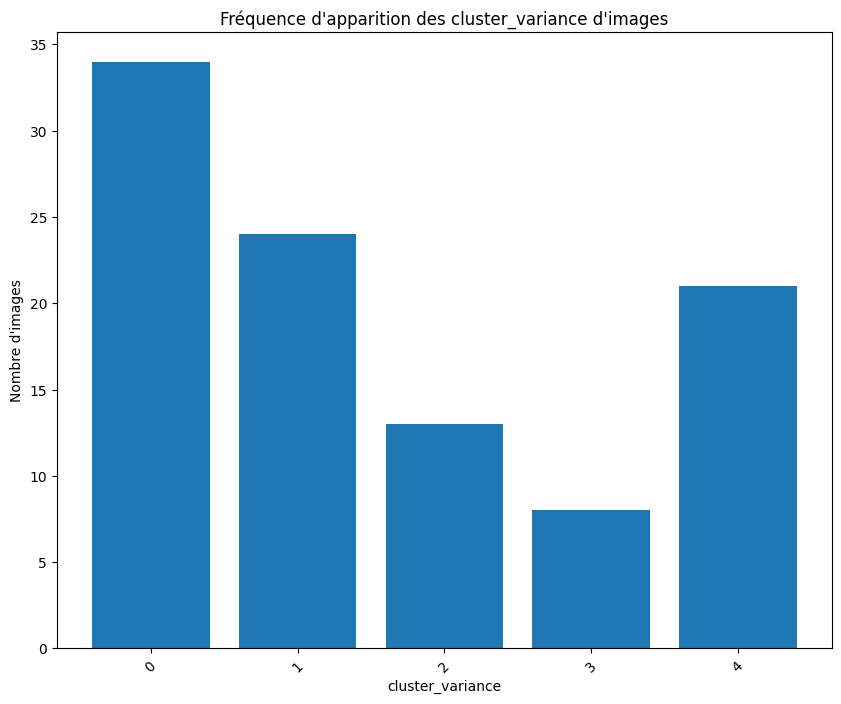

col is moment


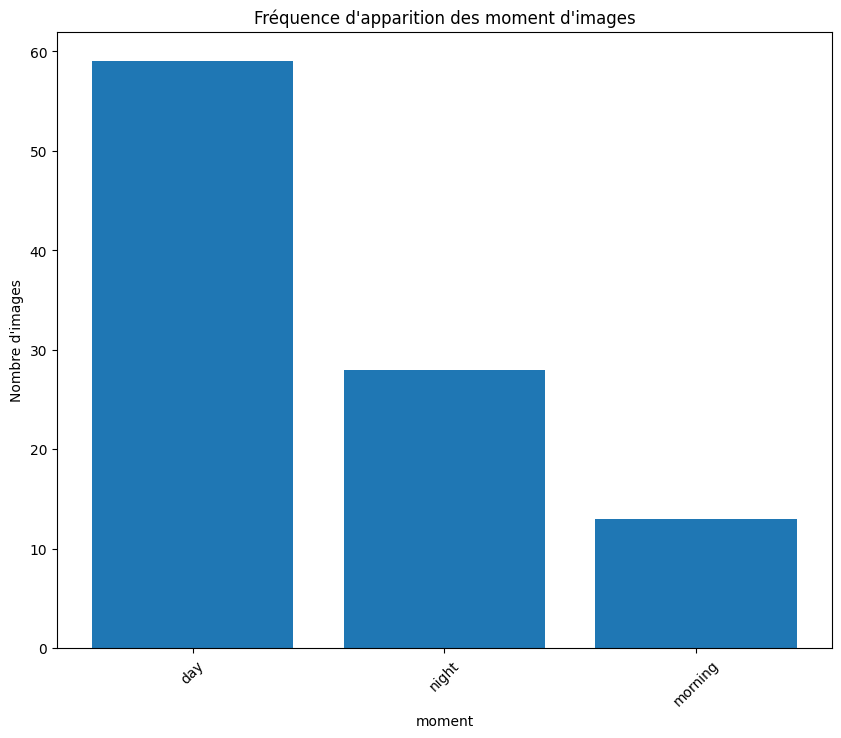

col is tag


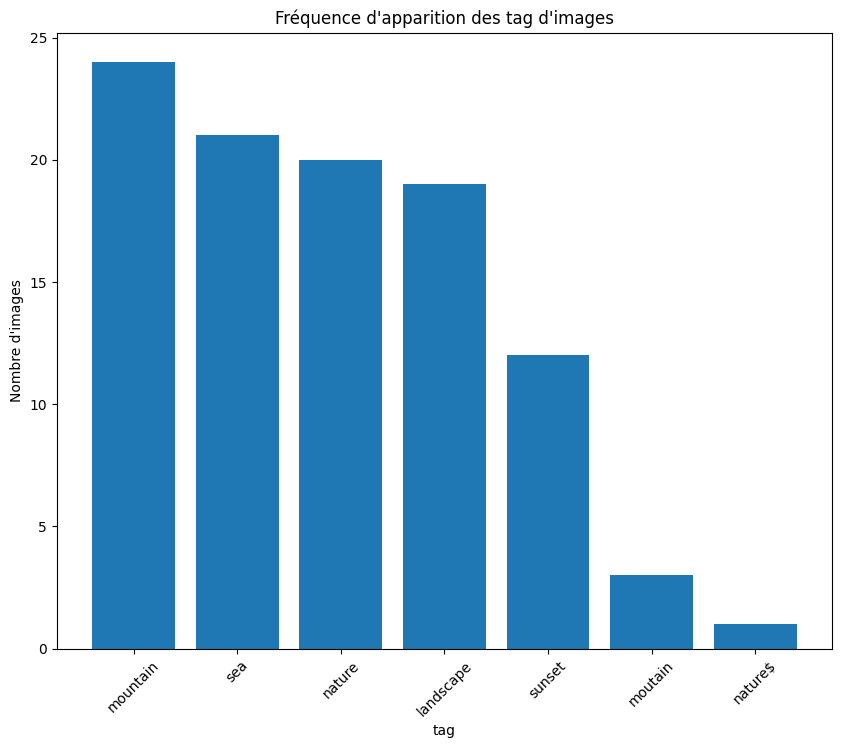

In [94]:
"""
Visualisation des données
"""
import Services as tool
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def visualisation(data):
    #Créer un DataFrame à partir des données JSON
    df = pd.DataFrame.from_dict(data, orient='index')

    """
    Affichage par années
    """
    # Compter l nombre d'images disponibles pour chaque année
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    #Extraire l'année à partir de la colonne "DateTime"
    df['year'] = pd.to_datetime(df['DateTime']).dt.year.astype(str)
    #Utiliser la méthode "value_counts" pour compter le nombre d'images pour chaque année
    count_by_year = df['year'].value_counts()

    #Créer une figure et un axe pour l'histogramme montrant la fréquence d'apparition des années
    fig, ax = plt.subplots()
    ax.hist(df['year'], bins=len(count_by_year))
    ax.set_title("Fréquence d'apparition des années")
    ax.set_xlabel('Années')
    ax.set_ylabel('Nombre d\'images')
    plt.xticks(rotation=45)
    fig.set_size_inches(10, 8)
    plt.show()



    """
    Affichage par couleur RGB
    """
    #Créer une figure et un axe pour l'histogramme montrant la fréquence d'apparition des couleurs RGB
    fig, ax = plt.subplots()
    # Extraire les valeurs des canaux de couleur RGB et les ajouter à des colonnes séparées dans le DataFrame
    df[["r", "g", "b"]] = df["rgb"].apply(pd.Series)

    # Compter la fréquence d'apparition de chaque couleur RGB
    value_counts = df.groupby(["r", "g", "b"]).size().reset_index(name="count")

    # Créer les colonnes R, G, et B en utilisant apply() et pd.Series()
    df[['R', 'G', 'B']] = df['rgb'].apply(pd.Series)
    # Calculer la fréquence de chaque intensité de chaque composante de couleur
    freq_r = df['R'].value_counts(normalize=True).sort_index()
    freq_g = df['G'].value_counts(normalize=True).sort_index()
    freq_b = df['B'].value_counts(normalize=True).sort_index()
    # Tracer une courbe pour chaque fréquence de couleur
    ax.plot(freq_r.index, freq_r.values, color='red', label='R')
    ax.plot(freq_g.index, freq_g.values, color='green', label='G')
    ax.plot(freq_b.index, freq_b.values, color='blue', label='B')
    # Ajouter une légende et des titres
    ax.legend()
    ax.set_xlabel('Intensité')
    ax.set_ylabel('Fréquence')
    ax.set_title('Fréquence des couleurs RGB')
    plt.show()

    """
    Affichage des autres attributs
    """
    ignore_col = ["DateTime", "filename", "ColorSpace", "rgb", "variances_rgb", "average_rgb"]
    #Créer un DataFrame à partir des données JSON
    df = pd.DataFrame.from_dict(data, orient='index')
    # Compter le nombre pour les différents types : taille de l'image, l'orientation des images, les modèles d'appareils photo, etc.
    for col in df.columns:
        if col not in ignore_col:
            print(f"col is {col}")
            # Utiliser la méthode value_counts() pour trouver la fréquence d'apparition de chaque valeur dans la colonne
            value_counts = df[col].value_counts()

            #Tracer un graphique à barres pour la fréquence d'apparition des tailles d'images
            fig, ax = plt.subplots()
            #value_counts = df['size'].value_counts()
            ax.bar(value_counts.index, value_counts.values)
            ax.set_title(f"Fréquence d'apparition des {col} d'images")
            ax.set_xlabel(f'{col}')
            ax.set_ylabel('Nombre d\'images')
            plt.xticks(rotation=45)
            fig.set_size_inches(10, 8)
            plt.show()


data = tool.get_json_metadata()
visualisation(data)

### Visualisation des données d'un utilisateur

In [ ]:
"""
Visualisation des données préférées de l'utilisateur
"""
import json
import matplotlib.pyplot as plt
import Services as tool

# Charger les informations des utilisateurs depuis le fichier JSON
with open('json/user_preference.json', 'r') as f:
    utilisateurs = json.load(f)

def visualize_preference_user(user_id):
    # Load metadata of images
    metadata = tool.get_json_metadata()
    
    # Sélectionner un utilisateur
    utilisateur_id = 1
    utilisateur = utilisateurs[utilisateur_id]

    # Visualiser les couleurs préférées
    images_preferes = utilisateur['favorite_images']
    print(utilisateur)

    # Store data of prefered images
    data = {}
    for img in images_preferes:
        data[img] = metadata[img]

    # Visualiser les préférences de l'utilisateur
    print(f"visualisation des préférences de l'utilisateur {utilisateur_id}")
    visualisation(data)
    
visualize_preference_user(user_id=0)

## Systèmes de recommendations 

### Basé sur le filtrage collaboratif

In [ ]:
"""
Recommandation basée sur le Filtrage collaboratif
"""
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load user preferences
with open('json/user_preference.json', 'r') as f:
    user_preferences = json.load(f)

# Load image metadata
with open('json/metadata.json', 'r') as f:
    metadata = json.load(f)

# Create user-item matrix
n_users = len(user_preferences)
n_items = len(metadata)
user_item_matrix = np.zeros((n_users, n_items))
for i, user in enumerate(user_preferences):
    for item in user['favorite_images']:
        j = list(metadata.keys()).index(item)
        user_item_matrix[i, j] = 1

# Compute cosine similarity matrix
user_similarity_matrix = cosine_similarity(user_item_matrix)

# Define a function to get similar users
def get_similar_users(user_id, user_similarity_matrix, n=5):
    similarities = user_similarity_matrix[user_id]
    most_similar_users = np.argsort(similarities)[-n-1:-1][::-1]
    return most_similar_users

# Define a function to predict ratings
def predict_ratings(user_id, item_id, user_item_matrix, user_similarity_matrix):
    similar_users = get_similar_users(user_id, user_similarity_matrix)
    item_ratings = user_item_matrix[similar_users, item_id]
    item_similarities = user_similarity_matrix[user_id, similar_users]
    prediction = np.dot(item_ratings, item_similarities) / item_similarities.sum()
    return prediction

# Define a function to get recommended items
def get_recommendations(user_id, user_item_matrix, user_similarity_matrix, metadata, n=5):
    unrated_items = np.where(user_item_matrix[user_id] == 0)[0]
    predicted_ratings = []
    for item_id in unrated_items:
        prediction = predict_ratings(user_id, item_id, user_item_matrix, user_similarity_matrix)
        predicted_ratings.append((metadata[list(metadata.keys())[item_id]]['filename'], prediction))
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)
    recommended_items = [item[0] for item in predicted_ratings[:n]]
    return recommended_items

user_id = 0
recommended_items = get_recommendations(user_id, user_item_matrix, user_similarity_matrix, metadata, n=5)
print("Recommended items for user", user_id, ":", recommended_items)

### Basé sur le contenu

In [120]:
"""
Système de préférence basé sur le contenu
"""
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import random
from sklearn.feature_extraction.text import CountVectorizer
import Services as tool
from Utilities import NumpyEncoder

    

def get_favorite_images(users, user_id):
    """
    Return favorite images of the user
    """
    for user in users:
        if user['user_id'] == user_id:
            return user['favorite_images']
    return []
        
    
def get_preferences(metadata, liked_images):
    """
    return preferences of a user
    """
    # Préparer les données d'entraînement et de test
    X = []  # caractéristiques des images
    y = []  # 0 si l'utilisateur n'aime pas l'image, 1 si l'utilisateur aime l'image

    # Créer un vectoriseur de texte
    vectorizer = CountVectorizer()
    
    preference_values = {"favorite_images": []}
    for i, key in enumerate(metadata):
        # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
        tags = metadata[key]['tag']
        try:
            # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
            tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
        except:
            tags_vector = 0

        # Ajouter les caractéristiques de l'image i à X
        X.append([metadata[key]['cluster_rgb'], metadata[key]['cluster_variance']])

        # Ajouter la réponse de l'utilisateur pour l'image i à y
        if key in liked_images:
            y.append(1)
        else:
            y.append(0)


    # Fractionnement des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entraînement de l'arbre de décision
    dt = DecisionTreeClassifier()
    # Entraîner le modèle sur les données d'entraînement
    dt.fit(X_train, y_train)


    image_positions = []
    recommended_images = []
    for i, key in enumerate(metadata):
            # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
            tags = metadata[key]['tag']
            try:
                # Convertir la caractéristique 'tags' en un vecteur numérique à l'aide du vectoriseur de texte
                tags_vector = vectorizer.fit_transform([tags]).toarray()[0][0]
            except:
                tags_vector = 0

            positions = [
                metadata[key]['filename'],
                metadata[key]['cluster_rgb'], 
                metadata[key]['cluster_variance'], 
                metadata[key]['tag'], 
                metadata[key]['size'], 
                metadata[key]['mode'], 
                metadata[key]['rgb'], 
                metadata[key]['average_rgb']
            ]
            if i in liked_images:
                positions.append('liked')
            # Vérifier si l'utilisateur a déjà aimé l'image i
            if i not in liked_images:

                # Prédire si l'utilisateur aimerait l'image i en utilisant le modèle DecisionTree
                prediction = dt.predict([[metadata[key]['cluster_rgb'], metadata[key]['cluster_variance']]])[0]
                # Si la prédiction est positive, ajouter l'image i aux images recommandées
                if prediction == 1:
                    recommended_images.append(key)
                    positions.append('recommended')
                else:
                    positions.append('not recommended')
                    #print("not recommanded")
            image_positions.append(positions)

  
    user_data = pd.DataFrame(image_positions, columns=['filename',
                                                       'cluster_rgb', 
                                                       'cluster_variance', 
                                                       'tag', 'size', 
                                                       'mode', 'rgb', 
                                                       'average_rgb', 'prediction'
                                                      ])

    recommended_user_data = user_data[(user_data['prediction'] == 'recommended')]
    recommended_files_list = recommended_user_data['filename'].tolist()
    # Sort recommended images by their position in the recommended_files_list
    recommended_images = sorted(recommended_images, key=lambda x: recommended_files_list.index(x), reverse=True)
    
    return recommended_images


# Load user preferences
with open('json/user_preference.json', 'r') as f:
    user_preferences = json.load(f)
    
# Load image metadata
with open('json/metadata.json', 'r') as f:
    metadata = json.load(f)
    
# analyze user preference profile
num_users = 10
users = []

for i in range(1, num_users+1):
    user = {'user_id': i+1}
    liked_images = get_favorite_images(user_preferences, user_id=i)
    recommended_images = get_preferences(metadata, liked_images)
    print(f"recommended images for user n°{i}: {recommended_images}\n")

recommended images for user n°1: ['img13.jpg', 'img91.jpg', 'img46.jpg', 'img28.jpg', 'img67.jpg', 'img81.jpg', 'img49.jpg', 'img94.jpg', 'img10.jpg', 'img25.jpg', 'img93.jpg', 'img78.jpg', 'img80.jpg', 'img50.jpg', 'img55.jpg', 'img68.jpg', 'img40.jpg', 'img66.jpg', 'img17.jpg', 'img73.jpg', 'img16.jpg', 'img12.jpg', 'img23.jpg', 'img57.jpg', 'img58.jpg', 'img98.jpg', 'img60.jpg', 'img76.jpg', 'img62.jpg', 'img11.jpg', 'img19.jpg']

recommended images for user n°2: ['img72.jpg', 'img95.jpg', 'img54.jpg', 'img91.jpg', 'img15.jpg', 'img46.jpg', 'img28.jpg', 'img56.jpg', 'img87.jpg', 'img67.jpg', 'img38.jpg', 'img68.jpg', 'img40.jpg', 'img7.jpg', 'img17.jpg', 'img73.jpg', 'img16.jpg', 'img82.jpg', 'img12.jpg', 'img9.jpg', 'img69.jpg', 'img98.jpg', 'img76.jpg', 'img19.jpg', 'img26.jpg']

recommended images for user n°3: ['img83.jpg', 'img56.jpg', 'img42.jpg', 'img81.jpg', 'img49.jpg', 'img41.jpg', 'img79.jpg', 'img10.jpg', 'img25.jpg', 'img50.jpg', 'img55.jpg', 'img66.jpg', 'img39.jpg', '